<hr>

# Procrustes Superimposition - Again!
_If you copy code, copy it right._

<hr>
Falk Mielke, Functional Morphology, Universiteit Antwerpen

You can download this notebook [here](user://notebooks/Procrustes.ipynb?download&target=_blank).

It is hard to say whether any procedure has been more central to my work than Procrustes Superimposition (the relevant competitors are few, namely Fourier Series, MCMC sampling, and Principal Component Analysis). 
Nevertheless, I keep coming back to old Procrustes, as I did today. 
I have so far achieved [two](https://doi.org/10.1007/s11692-018-9456-9?target=_blank) [publications](https://doi.org/10.1093/zoolinnean/zlz135?target=_blank) which introduce tweaks of the general procedure, and I'm currently working on a more subtle implementation which will use Procrustes as part of my own inverse dynamics workflow.


One reason might be the seemingly trivial goal of Procrustes Superimposition. 
When we see two forms, we compare them. 
Automatically. 
We compare **size, rotation, position and shape**. 
Even kids do that, all the time. 
Procrustes Superimposition is the quantitative way to compare, and it is surprisingly simple. 

I got primed on the matter when preparing my master's thesis in [John Nyakatura's lab](https://twitter.com/JohnNyakatura?target=_blank), working all through the excellent explanations by Norm MacLeod in his PalaeoMaths 101 column. The title was "[Who is Procrustes and What Has He Done With My Data?](https://www.palass.org/publications/newsletter/palaeomath-101/palaeomath-part-16-who-procrustes-and-what-has-he-done-my-data?target=_blank)". 
Then, for application, it started as so often with code copied from a [stack overflow response](https://stackoverflow.com/a/18927641?target=_blank) which someone got by inspiration from `matlab` (wouldn't matlab be better if it were all open source?) and which I've adapted for my purpose. 


Initially, I understood close to nothing. 


But over time, I (wrongly) adjusted the code, found mistakes, and understood more.
Only today, by coincidence, I fully understood the last enigmatic component (the "reflection" issue with SVD). 


My personal anecdote should serve as a motivation to students to go out there and use (and thereby gradually understand) the  uncountable piles of code they find online. 
I'll also take the occasion to briefly explain my Procrustes toolbox in the short blog post below.


Enjoy!



In [1]:
# The only library required herein is numpy.
import numpy as NP


# However, plotting increases the chance that someone reads this.
import matplotlib.pyplot as PLT

# Data Properties

All data are points will be organized in an $n\times m$ matrix, with n being the number of points, and m the dimension (always 3 with the code below). 
Mind your dimensions and signs! 
Some of the matrix operations further below are sensitive and can be found in inverse notation.

The following functions extract features of the data which are relevant.

In [2]:
def Centroid(pointset):
    # the centroid of the data.
    return NP.mean(pointset, axis = 0)


In [3]:
def RCS(pointset):
    # root centroid size, i.e. the scale of the data, defined as the root sum of 
    # euclidean distances of all points from their centroid.
    return NP.sqrt(NP.sum(NP.power(pointset-Centroid(pointset), 2), axis = (0,1) ))


# Transformation Operations

The following are rather trivial operations that change attributes of a data set.
While doing that, they store the exact modifications in a dictionary (see below).


In [4]:
def Center(pointset, trafo_history = None):
    # move all points so that the centroid is at the origin.
    centroid = Centroid(pointset)

    if trafo_history is not None:
        MakeHistory(trafo_history, translate = -centroid, log = 'center')

    return pointset - centroid




In [5]:
def UnitScale(pointset, trafo_history = None):
    # Scale the points so that RCS is one.
    rcs = RCS(pointset)
    
    if trafo_history is not None:        
        MakeHistory(trafo_history, scale = 1/rcs, log = 'unitscale')

    return pointset / rcs



In [6]:
def Rotate(pointset, rotation_matrix, trafo_history = None):
    # rotate a set of points
    # Note: usually (but not generally) it makes sense to center the points.
    centroid = Centroid(pointset)

    if trafo_history is not None:
        MakeHistory(trafo_history, rotate = rotation_matrix, log = 'rotate')

    return pointset.copy() @ rotation_matrix


Finally, it is useful to have a combined function that "standardizes" a form.

In [7]:

def Standardize(pointset, trafo_history = None):
    # Standardize a point set, i.e. center and scale to unity.
    pointset = Center(pointset.copy(), trafo_history)
    pointset = UnitScale(pointset, trafo_history)

    return pointset

# Making History 

While modifying objects, we would like to keep track of the things that happen. 
Obviously, this facilitates bug fixing. 

But what's more important, it allows to exapt a series of transformations to different point sets. 


In [8]:
# all starts with an empty history.
def GetEmptyHistory():
    # as history, I use dicts with defined keywords.
    return {key: [] for key in ['rotate', 'scale', 'translate', 'log']}

In [9]:
def MakeHistory(hist, scale = 1., translate = NP.zeros((3,)), rotate = NP.eye(3), log = ''):
    # This convenience function is used to appended actions to a history dict.  
    hist['scale'].append(scale)
    hist['translate'].append(translate)
    hist['rotate'].append(rotate)
    hist['log'].append(log)



In [10]:
def InvertHistory(trafo_history):
    # this inverts the course of actions to exactly undo a series of transformations.
    # (not fully tested)
    inverted_history = GetEmptyHistory()
    for shift, scale, rotation_matrix, log in zip(trafo_history['translate'], trafo_history['scale'], trafo_history['rotate'], trafo_history['log']):
        MakeHistory(inverted_history, scale = 1/scale, translate = -shift, rotate = rotation_matrix.T, log = f'{log} (inverted)')

    return inverted_history

And here is the function that allows to apply a superimposition to a separate point set:

In [11]:
def ApplyTransformations(points, trafo_history):
    # This will apply a previously stored series of transformations to data.
    points = points.copy()
    for shift, scale, rotation_matrix in zip(trafo_history['translate'], trafo_history['scale'], trafo_history['rotate']):
        points = scale * Rotate(points, rotation_matrix) + shift

    return points


Hopefully few conceptual challenges so far. But maybe the procedures, when broken down into simple functions, just "loose their magic" quicker.

# Toy Data

I will first go through the procedure step by step, before pasting a single function which you can copy and use elsewhere.

**Procrustes Superimposition will remove differences between two objects in position, scale, and rotation, thereby leaving them to differ only in shape.**


Historically, Procrustes specialists work on triangles. [I prefer smileys](https://static-content.springer.com/esm/art%3A10.1007%2Fs11692-018-9456-9/MediaObjects/11692_2018_9456_MOESM5_ESM.zip?target=_blank).

In [12]:
data = {\
"face1": NP.array([ \
          [13.341144, 41.916090] \
        , [23.635776, 42.184095] \
        , [18.529748, 43.532775] \
        , [17.430506, 46.945969] \
        , [11.763092, 50.847553] \
        , [12.274600, 51.681412] \
        , [13.395186, 52.105268] \
        , [14.999929, 52.204998] \
        , [16.963911, 52.066484] \
        , [19.162211, 51.775603] \
        , [21.469911, 51.418235] \
        , [23.762091, 51.080258] \
        , [25.913831, 50.847551] \
        ]) \
, "face2": NP.array([ \
          [91.405685, 13.157473] \
        , [101.00032, 12.467501] \
        , [96.532169, 14.142255] \
        , [97.082454, 17.007084] \
        , [89.127633, 19.904976] \
        , [91.119536, 20.980855] \
        , [93.025648, 21.712223] \
        , [94.856997, 22.117637] \
        , [96.624615, 22.215657] \
        , [98.339531, 22.024843] \
        , [100.01278, 21.563752] \
        , [101.65538, 20.850943] \
        , [103.27837, 19.904975] \
        ])
}

data = {k: NP.concatenate([v, NP.linspace(0, (float(k[-1])-1.)*0.2, v.shape[0]).reshape([-1,1])], axis = 1) \
       for k, v in data.items()}
data['face1'] *= 1.5
data['face2'] -= 40
data['face1'][:, 1] -= 80

data

{'face1': array([[ 20.011716 , -17.125865 ,   0.       ],
        [ 35.453664 , -16.7238575,   0.       ],
        [ 27.794622 , -14.7008375,   0.       ],
        [ 26.145759 ,  -9.5810465,   0.       ],
        [ 17.644638 ,  -3.7286705,   0.       ],
        [ 18.4119   ,  -2.477882 ,   0.       ],
        [ 20.092779 ,  -1.842098 ,   0.       ],
        [ 22.4998935,  -1.692503 ,   0.       ],
        [ 25.4458665,  -1.900274 ,   0.       ],
        [ 28.7433165,  -2.3365955,   0.       ],
        [ 32.2048665,  -2.8726475,   0.       ],
        [ 35.6431365,  -3.379613 ,   0.       ],
        [ 38.8707465,  -3.7286735,   0.       ]]),
 'face2': array([[ 51.405685  , -26.842527  , -40.        ],
        [ 61.00032   , -27.532499  , -39.98333333],
        [ 56.532169  , -25.857745  , -39.96666667],
        [ 57.082454  , -22.992916  , -39.95      ],
        [ 49.127633  , -20.095024  , -39.93333333],
        [ 51.119536  , -19.019145  , -39.91666667],
        [ 53.025648  , -18.2877

The first four points are "eyes" and "nose", the other are mouthpoints. Note that, ideally, points must be biologically homologous, and I will resist my urge to rant about the overuse of "semilandmarks" (here: the ones on the mouth line).  

**Our goal is to superimpose the second face onto the first.**

Instead of calling them "`face1`" and "`face2`", or second and first, I prefer calling the reference one "reference". Deep copies with `.copy()` are used to make sure we don't accidentally change our raw data.

In [13]:
referenceform = data['face1'].copy()
focalform = data['face2'].copy()

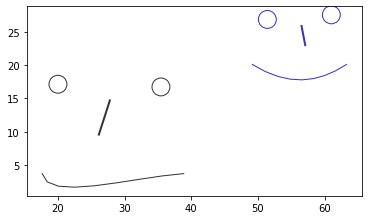

In [14]:
def PlotForms(form1, form2):
    for form, color in zip([form1, form2], [(0.2, 0.2, 0.2), (0.2, 0.2, 0.8)]):
        PLT.scatter(form[:2,0], -form[:2,1], s = 320, edgecolor = color, marker = 'o', facecolor = 'none')
        PLT.plot(form[2:4,0], -form[2:4,1], color = color, lw = 2, ls = '-')
        PLT.plot(form[4:,0], -form[4:,1], color = color, lw = 1, ls = '-')
    
    PLT.gca().set_aspect('equal')
    PLT.show();
PlotForms(referenceform, focalform)

You can intuitively see that these "faces" differ in position, size, and in the way their mouths curl. 
It is harder to guess whether they differ in rotation.

And it is impossible to quantify "by eye" how different they are.

# Procrustes Superimposition

### Position and Scaling

This is trivial, because we can "center" and "unit scale" objects with the little helper functions above. The combination is sometimes called "standardization" (although a proper standardization should also involve a default rotation).

We will store the raw centroid and RCS for later.

In [15]:
ref_centroid = Centroid(referenceform)
ref_rcs = RCS(referenceform)

Then get both forms standardized.

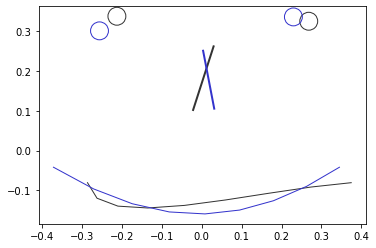

In [16]:
referenceform = Standardize(referenceform)
focalform = Standardize(focalform)

PlotForms(referenceform, focalform)

Voila! Still, rotation *might* differ (see eyes and noses)...

### Rotation

Finding the matchmaking rotation is a bit more tricky. 
I found [this blog post showing the quickest solution](http://nghiaho.com/?page_id=671&target=_blank) and further reading in the [Kwon archives](http://www.kwon3d.com/theory/jkinem/rotmat.html?target=_blank) (where else?).



Our goal is to superimpose the *focal form* onto the *reference form* (remember that; operation order and transposes are important below). 
Start by calculating a cross dispersion matrix, which is in fact the correlation matrix of the two point sets.

In [17]:
cross_dispersion = focalform.T @ referenceform
cross_dispersion

array([[ 0.5778951 , -0.00657539,  0.        ],
       [-0.05410947,  0.40692786,  0.        ],
       [ 0.00419021,  0.00580516,  0.        ]])

The [matrix product `@`](https://medium.com/analytics-vidhya/python-matrix-multiplication-using-a-dedicated-infix-operator-b0a41b68904f?target=_blank) is a recent and very convenient notation in `numpy` (it used to be the overloaded `NP.dot` function). 

Next, perform singular value decomposition of that matrix. 
**What is singular value decomposition?** 
Well, I would argue that SVD is maybe the best reason to ever visit a lecture in linear algebra. 
It's relevant and has many applications (e.g. Principal Component Analysis). Spend some time to read it up, try it on your favorite matrices, and digest what you need for application.  

In [18]:
U, singular_values, V = NP.linalg.svd(cross_dispersion, full_matrices = False)

But note: the **SVD can occasionaly yield a "reflected" outcome.** 
I guess this happens if the forms are more similar if one of them is mirrored. 

This can be intended in some applications. 
For me, it led to nonsense results because mirroring made no sense; I had to debug for two days, which ultimately made me start this text. 

You can identify such "reflection" cases by testing if the determinant of the rotation matrix (see below) is negative, or by checking the $U$/$V$ determinant product. 
Then, adjustment works by two sign flips. 

In [19]:
# rectify the mirrored outcomes
if (NP.linalg.det(U) * NP.linalg.det(V)) < 0.0:
    U[:, -1] = -U[:, -1]
    singular_values[-1] *= -1


The singular values can be of further relevance: their magnitude (`sum`) might be different from $1$, which must be regarded for scaling. And they are used to calculate procrustes distance.

In [20]:
singular_value_trace = singular_values.sum()

# standarised distance 
procrustes_distance = 1 - singular_value_trace**2

# optimum scaling of data
scaling_factor = singular_value_trace * ref_rcs / RCS(focalform)


With the definitions and operator order above, one can get the rotation matrix R as follows:

In [21]:
rotation_matrix = U @ V
rotation_matrix

array([[ 0.99880365,  0.04813866, -0.00859836],
       [-0.04825915,  0.998731  , -0.01440275],
       [ 0.00789412,  0.01480047,  0.9998593 ]])

Finally, we can apply the transformation. Note that the reference face was not changed in the process (e.g. not centered).

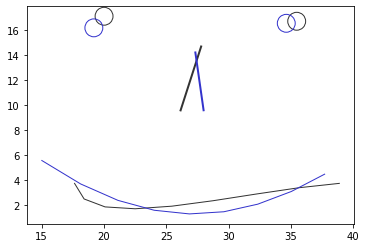

In [22]:
transformed_data =  Rotate(focalform, rotation_matrix) \
                    * scaling_factor \
                  + ref_centroid


PlotForms(data['face1'], transformed_data)

Rotation was tiny, but actually had an effect, as you can see from the reduced "*chiasmus nasale*" and from the eyes.

Believe it or not: This is the "perfect" superimposition of the two faces - iff you find the maths a perfect criterium, and given that you can ignore the overrepresention of the mouth part (think more about this before sputtering your scans with semi-landmarks). 

The algorithm involved in rotation goes under [Kabsch algorithm](https://en.wikipedia.org/wiki/Kabsch_algorithm?target=_blank) or [Wahba's problem](https://en.wikipedia.org/wiki/Wahba%27s_problem?target=_blank), and see also the [Orthogonal Procrustes problem](https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem?target=_blank). 


## In a Nutshell

All this, spiced up with the creation of a log of the involved steps, can be put into a function:

In [23]:
def Procrustes(focalform_raw, referenceform_raw, trafo_history = None):
    # http://stackoverflow.com/questions/18925181/procrustes-analysis-with-numpy
    # input forms must be numpy arrays of the shape [points, dimensions]

    ## work on copies, to be safe
    referenceform = referenceform_raw.copy()
    focalform = focalform_raw.copy()

    ## match nr of points and nr of dimensions
    if (not referenceform.shape[0] == focalform.shape[0]) or (not referenceform.shape[1] == focalform.shape[1]):
        raise IOError('forms must be of the same "shape" (Procrustes/numpy joke :)')

    ## store transformations
    if trafo_history is None:
        trafo_history = GetEmptyHistory()


    ## standardize
    referenceform = Standardize(referenceform)
    focalform = Standardize(focalform, trafo_history)


    ## rotation
    # optimum rotation matrix of focal form
    # cf. http://nghiaho.com/?page_id=671

    # calculate cross-dispersion (correlation) matrix (cf. http://www.kwon3d.com/theory/jkinem/rotmat.html)
    cross_dispersion =  focalform.T @ referenceform
    
    # singular value decomposition of cross-dispersion matrix
    U, singular_values, V = NP.linalg.svd(cross_dispersion, full_matrices = False)
    

    # if R has negative determinant, it is a reflection matrix and must be modified.
    if (NP.linalg.det(U) * NP.linalg.det(V)) < 0.0:
        U[:, -1] = -U[:, -1]
        singular_values[-1] *= -1

    # ... to get the rotation matrix R as follows:
    rotation_matrix = U @ V

    ## further Procrustes measures
    singular_value_trace = singular_values.sum()

    # standarised distance 
    procrustes_distance = 1 - singular_value_trace**2


    ## scaling
    # optimum scaling of data
    scaling_factor = singular_value_trace * RCS(referenceform_raw) / RCS(focalform)


    ## transformation
    # ref_rcs = RCS(referenceform_raw)
    ref_centroid = Centroid(referenceform_raw)
    transformed_data =  Rotate(focalform, rotation_matrix) \
                        * scaling_factor \
                      + ref_centroid


    ## log
    MakeHistory(trafo_history \
                , rotate = rotation_matrix \
                , scale = scaling_factor \
                , translate = ref_centroid \
                , log = 'procrustes' \
                )


    # return transformed data, residual distance, and log
    return transformed_data, procrustes_distance, trafo_history



With this at hand, enjoy turning all your forms into shapes!

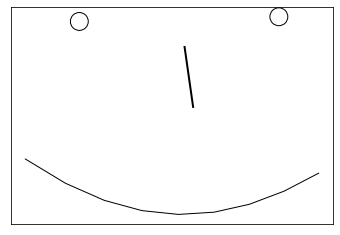

In [24]:
traform, pd, history = Procrustes(focalform, referenceform)


PLT.scatter(traform[:2,0], -traform[:2,1], s = 320, edgecolor = 'k', marker = 'o', facecolor = 'none')
PLT.plot(traform[2:4,0], -traform[2:4,1], color = 'k', lw = 2, ls = '-')
PLT.plot(traform[4:,0], -traform[4:,1], color = 'k', lw = 1, ls = '-')

PLT.gca().set_aspect('equal')
PLT.gca().get_xaxis().set_visible(False)
PLT.gca().get_yaxis().set_visible(False)
PLT.show();

**UPDATE 2020/09/28:** added reference to Kabsch algorithm; matrix products with `@`; corrected minor bug in the RCS calculation.